#### Outline
- for each dataset: 
    - load dataset; 
    - for each network: 
        - load network
        - project training data
        - project testing data
        - train KNN classifier (k=1)
        - save results to dataframe

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=''

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=''


In [3]:
import numpy as np
import pickle
import pandas as pd
import time
from umap import UMAP

In [4]:
from tfumap.umap import tfUMAP
import tensorflow as tf
from sklearn.decomposition import PCA
from openTSNE import TSNE

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
from sklearn.neighbors import KNeighborsClassifier

In [6]:
from tqdm.autonotebook import tqdm

In [7]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [8]:
output_dir = MODEL_DIR/'projections' 

In [9]:
KNN_results_df = pd.DataFrame(columns = ['method_', 'dimensions', 'dataset', '1NN_acc', '5NN_acc'])

### MNIST

In [10]:
dataset = 'cifar10'
dims = (32,32,3)

##### load dataset

In [11]:
from tensorflow.keras.datasets import cifar10

# load dataset
(train_images, Y_train), (test_images, Y_test) = cifar10.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:].flatten()
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid].flatten()
Y_test = Y_test.flatten()

print(len(X_train), len(X_valid), len(X_test))
X_test_flat = X_test
X_train_flat = X_train

40000 10000 10000


#### Network 

##### 2 dims

In [12]:
load_loc = output_dir / dataset / 'network' 

In [13]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    batch_size = 100,
    dims = dims
)

In [14]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [15]:
Z_train = embedder.transform(X_train_flat);
Z_test = embedder.transform(X_test_flat);

In [16]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(Z_train, Y_train)
score_5nn = neigh5.score(Z_test, Y_test)
score_5nn

0.1722

In [17]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(Z_train, Y_train)
score_1nn = neigh1.score(Z_test, Y_test)

In [18]:
import matplotlib.pyplot as plt

In [19]:
KNN_results_df.loc[len(KNN_results_df)] = ['network', 2, dataset, score_1nn, score_5nn]

In [20]:
KNN_results_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,cifar10,0.1512,0.1722


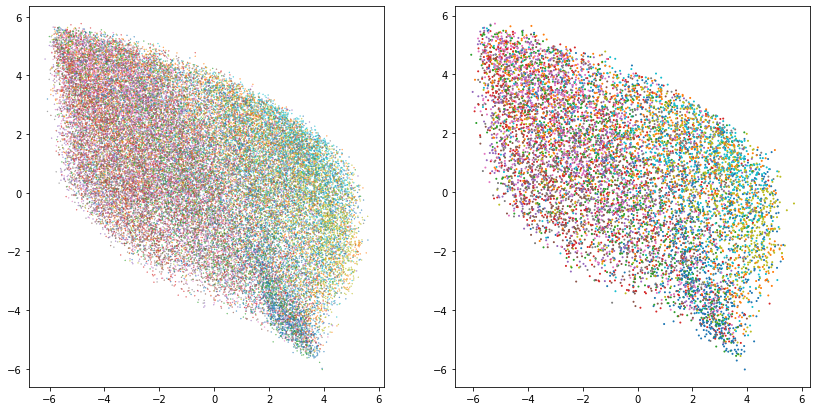

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
axs[0].scatter(Z_train[:,0], Z_train[:,1], c= Y_train, s = 0.1, cmap = plt.cm.tab10)
axs[1].scatter(Z_test[:,0], Z_test[:,1], c= Y_test, s = 1, cmap = plt.cm.tab10)

##### 64 dims

In [22]:
load_loc = output_dir / dataset /"64"/ 'network' 

In [23]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    batch_size = 100,
    dims = dims
)

In [24]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [25]:
Z_train = embedder.transform(X_train_flat);
Z_test = embedder.transform(X_test_flat);

neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(Z_train, Y_train)
score_5nn = neigh5.score(Z_test, Y_test)
score_5nn

neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(Z_train, Y_train)
score_1nn = neigh1.score(Z_test, Y_test)

KNN_results_df.loc[len(KNN_results_df)] = ['network', 64, dataset, score_1nn, score_5nn]

KNN_results_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,cifar10,0.1512,0.1722
1,network,64,cifar10,0.2139,0.2519


### AE 

##### 2 dims

In [26]:
load_loc = output_dir / dataset / 'autoencoder' 

In [27]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "autoencoder",
    batch_size = 100,
    dims = dims
)

In [28]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [29]:
Z_train = embedder.transform(X_train_flat);
Z_test = embedder.transform(X_test_flat);

neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(Z_train, Y_train)
score_5nn = neigh5.score(Z_test, Y_test)
score_5nn

neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(Z_train, Y_train)
score_1nn = neigh1.score(Z_test, Y_test)

KNN_results_df.loc[len(KNN_results_df)] = ['autoencoder', 2, dataset, score_1nn, score_5nn]

KNN_results_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,cifar10,0.1512,0.1722
1,network,64,cifar10,0.2139,0.2519
2,autoencoder,2,cifar10,0.1592,0.1833


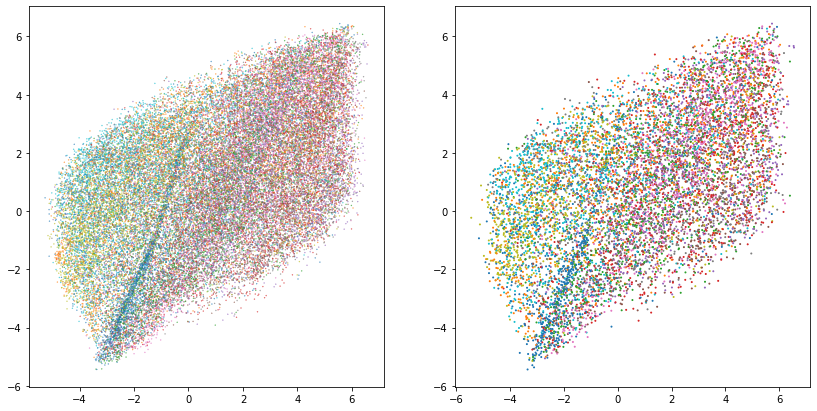

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
axs[0].scatter(Z_train[:,0], Z_train[:,1], c= Y_train, s = 0.1, cmap = plt.cm.tab10)
axs[1].scatter(Z_test[:,0], Z_test[:,1], c= Y_test, s = 1, cmap = plt.cm.tab10)

##### 64 dims

In [31]:
load_loc = output_dir / dataset /"64"/ 'autoencoder' 

In [32]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "autoencoder",
    batch_size = 100,
    dims = dims
)

In [33]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [34]:
Z_train = embedder.transform(X_train_flat);
Z_test = embedder.transform(X_test_flat);

neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(Z_train, Y_train)
score_5nn = neigh5.score(Z_test, Y_test)
score_5nn

neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(Z_train, Y_train)
score_1nn = neigh1.score(Z_test, Y_test)

KNN_results_df.loc[len(KNN_results_df)] = ['autoencoder', 64, dataset, score_1nn, score_5nn]

KNN_results_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,cifar10,0.1512,0.1722
1,network,64,cifar10,0.2139,0.2519
2,autoencoder,2,cifar10,0.1592,0.1833
3,autoencoder,64,cifar10,0.2223,0.2477


#### UMAP-learn

##### 2 dims

In [35]:
embedder = UMAP(n_components = 2, verbose=True)
z_umap = embedder.fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Fri Jul 17 00:09:13 2020 Finding Nearest Neighbors
Fri Jul 17 00:09:13 2020 Building RP forest with 15 trees
Fri Jul 17 00:09:16 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Fri Jul 17 00:09:28 2020 Finished Nearest Neighbor Search
Fri Jul 17 00:09:30 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jul 17 00:10:16 2020 Finished embedding


In [36]:
Z_train = embedder.transform(X_train_flat);
Z_test = embedder.transform(X_test_flat);

neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(Z_train, Y_train)
score_5nn = neigh5.score(Z_test, Y_test)
score_5nn

neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(Z_train, Y_train)
score_1nn = neigh1.score(Z_test, Y_test)

KNN_results_df.loc[len(KNN_results_df)] = ['umap-learn', 2, dataset, score_1nn, score_5nn]

KNN_results_df

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,cifar10,0.1512,0.1722
1,network,64,cifar10,0.2139,0.2519
2,autoencoder,2,cifar10,0.1592,0.1833
3,autoencoder,64,cifar10,0.2223,0.2477
4,umap-learn,2,cifar10,0.1689,0.1936


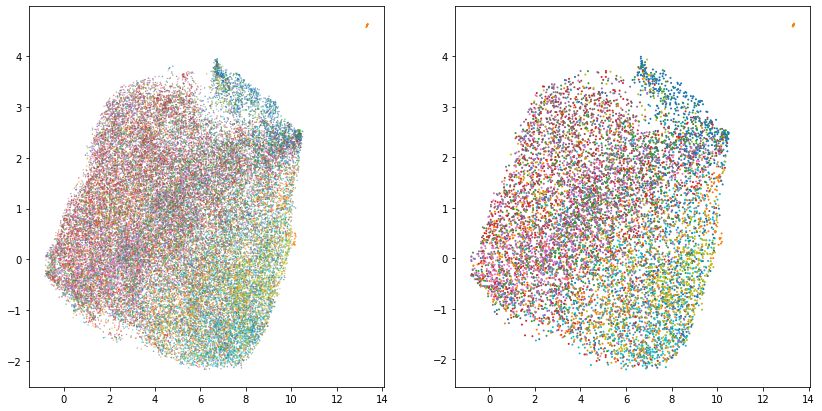

In [37]:
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
axs[0].scatter(Z_train[:,0], Z_train[:,1], c= Y_train, s = 0.1, cmap = plt.cm.tab10)
axs[1].scatter(Z_test[:,0], Z_test[:,1], c= Y_test, s = 1, cmap = plt.cm.tab10)

##### 64 dims

In [38]:
embedder = UMAP(n_components = 64, verbose=True)
z_umap = embedder.fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, n_components=64, verbose=True)
Construct fuzzy simplicial set
Fri Jul 17 00:10:55 2020 Finding Nearest Neighbors
Fri Jul 17 00:10:55 2020 Building RP forest with 15 trees
Fri Jul 17 00:11:03 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Fri Jul 17 00:11:08 2020 Finished Nearest Neighbor Search
Fri Jul 17 00:11:09 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jul 17 00:12:13 2020 Finished embedding


In [39]:
Z_train = embedder.transform(X_train_flat);
Z_test = embedder.transform(X_test_flat);

neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(Z_train, Y_train)
score_5nn = neigh5.score(Z_test, Y_test)
score_5nn

neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(Z_train, Y_train)
score_1nn = neigh1.score(Z_test, Y_test)

KNN_results_df.loc[len(KNN_results_df)] = ['umap-learn', 64, dataset, score_1nn, score_5nn]

KNN_results_df

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,cifar10,0.1512,0.1722
1,network,64,cifar10,0.2139,0.2519
2,autoencoder,2,cifar10,0.1592,0.1833
3,autoencoder,64,cifar10,0.2223,0.2477
4,umap-learn,2,cifar10,0.1689,0.1936
5,umap-learn,64,cifar10,0.2375,0.2694


#### PCA

##### 2 dims

In [40]:
pca = PCA(n_components=2)
z = pca.fit_transform(X_train_flat)

In [41]:
Z_train = pca.transform(X_train_flat);
Z_test = pca.transform(X_test_flat);

neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(Z_train, Y_train)
score_5nn = neigh5.score(Z_test, Y_test)
score_5nn

neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(Z_train, Y_train)
score_1nn = neigh1.score(Z_test, Y_test)

KNN_results_df.loc[len(KNN_results_df)] = ['PCA', 2, dataset, score_1nn, score_5nn]

KNN_results_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,cifar10,0.1512,0.1722
1,network,64,cifar10,0.2139,0.2519
2,autoencoder,2,cifar10,0.1592,0.1833
3,autoencoder,64,cifar10,0.2223,0.2477
4,umap-learn,2,cifar10,0.1689,0.1936
5,umap-learn,64,cifar10,0.2375,0.2694
6,PCA,2,cifar10,0.1436,0.1503


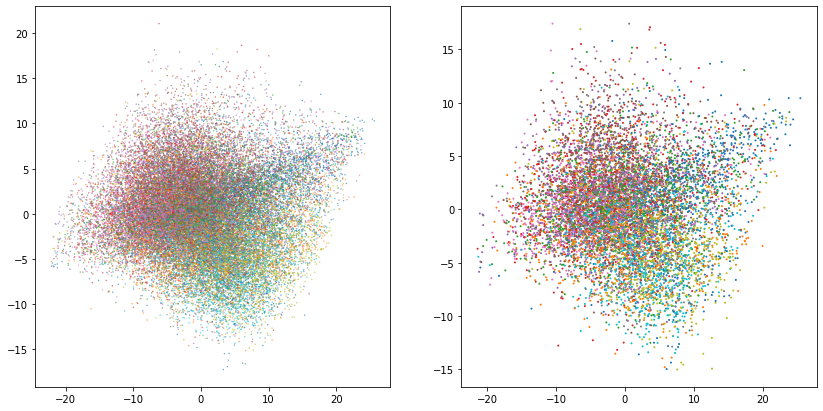

In [42]:
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
axs[0].scatter(Z_train[:,0], Z_train[:,1], c= Y_train, s = 0.1, cmap = plt.cm.tab10)
axs[1].scatter(Z_test[:,0], Z_test[:,1], c= Y_test, s = 1, cmap = plt.cm.tab10)

##### 64 dims

In [43]:
pca = PCA(n_components=64)
z = pca.fit_transform(X_train_flat)

In [44]:
Z_train = pca.transform(X_train_flat);
Z_test = pca.transform(X_test_flat);

neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(Z_train, Y_train)
score_5nn = neigh5.score(Z_test, Y_test)
score_5nn

neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(Z_train, Y_train)
score_1nn = neigh1.score(Z_test, Y_test)

KNN_results_df.loc[len(KNN_results_df)] = ['PCA', 64, dataset, score_1nn, score_5nn]

KNN_results_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,cifar10,0.1512,0.1722
1,network,64,cifar10,0.2139,0.2519
2,autoencoder,2,cifar10,0.1592,0.1833
3,autoencoder,64,cifar10,0.2223,0.2477
4,umap-learn,2,cifar10,0.1689,0.1936
5,umap-learn,64,cifar10,0.2375,0.2694
6,PCA,2,cifar10,0.1436,0.1503
7,PCA,64,cifar10,0.3829,0.3769


#### TSNE

##### 2 dims

In [45]:
tsne = TSNE(
    n_components = 2,
    n_jobs=32,
    verbose=True
)

In [46]:
embedding_train = tsne.fit(X_train_flat)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


--------------------------------------------------------------------------------
TSNE(n_jobs=32, neighbors=None, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 88.53 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.36 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 1.25 seconds
===> Running optimization with exaggeration=12.00, lr=3333.33 for 250 iterations...
Iteration   50, KL divergence 6.7066, 50 iterations in 1.8201 sec
Iteration  100, KL divergence 6.5047, 50 iterations in 3.5830 sec
Iteration  150, KL divergence 6.3265, 50 iterations in 4.4749 sec
Iteration  200, KL divergence 6.3892, 50 iterations in 6.7121 sec
Iteration  250, KL divergence 6.3070, 50 iterations in 5.0468 sec
   --> Time elapsed: 21.64 seconds
===> Running optimization with exaggeration=1.00, lr=3333.33 for 5

In [47]:
Z_train = np.array(embedding_train)
Z_test = embedding_train.transform(X_test_flat);

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 10.39 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 193789.4521, 50 iterations in 0.3027 sec
Iteration  100, KL divergence 193774.8470, 50 iterations in 0.3012 sec
Iteration  150, KL divergence 193772.6544, 50 iterations in 0.3411 sec
Iteration  200, KL divergence 193777.1838, 50 iterations in 0.2764 sec
Iteration  250, KL divergence 193764.6030, 50 iterations in 0.2937 sec
   --> Time elapsed: 1.52 seconds


In [48]:
Z_train = np.array(embedding_train)
Z_test = embedding_train.transform(X_test_flat);

neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(Z_train, Y_train)
score_5nn = neigh5.score(Z_test, Y_test)
score_5nn

neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(Z_train, Y_train)
score_1nn = neigh1.score(Z_test, Y_test)

KNN_results_df.loc[len(KNN_results_df)] = ['TSNE', 2, dataset, score_1nn, score_5nn]

KNN_results_df

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 10.59 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 193789.4521, 50 iterations in 0.2627 sec
Iteration  100, KL divergence 193774.8470, 50 iterations in 0.2839 sec
Iteration  150, KL divergence 193772.6544, 50 iterations in 0.2621 sec
Iteration  200, KL divergence 193777.1838, 50 iterations in 0.3240 sec
Iteration  250, KL divergence 193764.6030, 50 iterations in 0.2690 sec
   --> Time elapsed: 1.40 seconds


,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,cifar10,0.1512,0.1722
1,network,64,cifar10,0.2139,0.2519
2,autoencoder,2,cifar10,0.1592,0.1833
3,autoencoder,64,cifar10,0.2223,0.2477
4,umap-learn,2,cifar10,0.1689,0.1936
5,umap-learn,64,cifar10,0.2375,0.2694
6,PCA,2,cifar10,0.1436,0.1503
7,PCA,64,cifar10,0.3829,0.3769
8,TSNE,2,cifar10,0.2457,0.2608


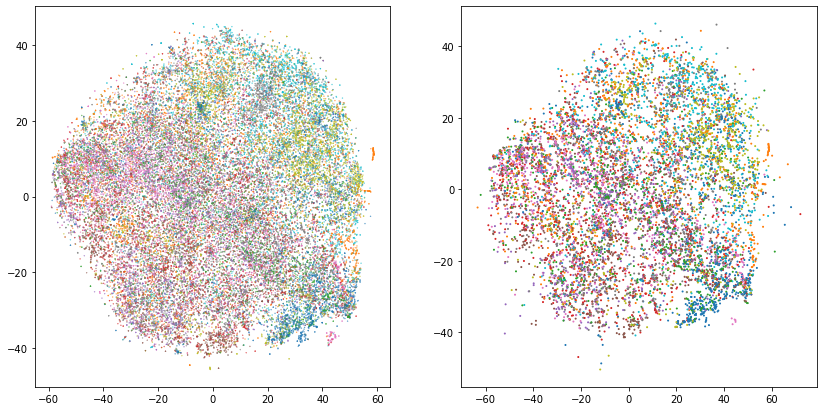

In [49]:
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
axs[0].scatter(Z_train[:,0], Z_train[:,1], c= Y_train, s = 0.1, cmap = plt.cm.tab10)
axs[1].scatter(Z_test[:,0], Z_test[:,1], c= Y_test, s = 1, cmap = plt.cm.tab10)

### Save

In [50]:
save_loc = DATA_DIR / 'knn_classifier' / (dataset + '.pickle')
ensure_dir(save_loc)
KNN_results_df.to_pickle(save_loc)